In [17]:
import numpy as np
import numpy.linalg as la
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import os
import re
import lncrna_analysis_helper as lh
import h5py
import pickle as pkl
import fipy as fp

In [51]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['font.size']=20

### Free energy and chemical potential of lncRNA in the absence of protein

The free energy of the lncRNA with an attractive well in the absence of proteins for the modified FH model is given by:

(Refer notes from **20210827 - Equivalence between our LG-Expression and a FH model**)

$F(\phi_R) = f_{bulk}(\phi_R) - K e^{-r^2/L_R^2}$

Where,

$f_{bulk}(\phi_R) = \frac{\phi_R}{N_R} \ln(\phi_R) + \frac{|\epsilon_R|+1}{2}\phi_R^2$

$\rho_R = \frac{|\epsilon_R|+1}{2}$

The corresponding chemical potential is:

$\mu(\phi_R) = \frac{1+\log(\phi_R)}{N_R} + 2\rho_R\phi_R - K e^{-r^2/L_R^2}$

## Save concentration profiles for different K and phi_r

In [ ]:
### Saving the lncRNA profiles as separate files

def save_lncRNA_profile(phi_r_list, l_list, target_directory, name_pattern, 
                        param_file='input_params.txt', 
                        spatial_variables_file='spatial_variables.hdf5', nx=300, dx=0.1):
    
    """
    Function to read through directories that contain lncRNA concentration data and store the concentration profiles 
    as pickle files in their corresponding directory
    """    

    for i in range(len(phi_r_list)):
        
        for j in range(len(l_list)):
    
            pattern = name_pattern.format(phi_r=phi_r_list[i],l=l_list[j])

            for root, dirs, files in os.walk(target_directory):

                regex = re.compile(pattern)
                match = re.search(regex, root)

                if match != None:

                    # Read values of input parameters from param_file
                    input_param_file = root + '/' + param_file
                    input_parameters = lh.input_parse(input_param_file)
                    if input_parameters['nx'] != nx or input_parameters['dx'] != dx:
                        nx = input_parameters['nx']
                        dx = input_parameters['dx']

                    mesh = lh.create_circular_mesh(radius=float(nx)*dx/2,cellSize=dx*1.5)
                    spatial_variable_hdf5_file_name = root + '/' + spatial_variables_file
                    with h5py.File(spatial_variable_hdf5_file_name) as sp_f:
                        counter = 1
                        while np.sum(sp_f['phi_r'][-counter]) == 0.0:
                            counter = counter + 1
                        phi_r = np.array(sp_f['phi_r'][-counter])
                        with open(root + '/phi_r_ss.pkl','wb') as f:
                            pkl.dump(phi_r, f)

In [ ]:
phi_r_list = [0.001, 0.002, 0.005, 0.01]
l_list = [2.0, 6.0, 8.0, 10.0, 15.0]
target_directory = '/nfs/arupclab001/npradeep96/PhaseField/RNA_EQBM_PROFILE/K_0.2/'
name_pattern = "phi_p0_.*_L_P_{l}_.*_phi_r_0{phi_r}$"
save_lncRNA_profile(phi_r_list=phi_r_list, l_list=l_list, target_directory=target_directory, 
                    name_pattern=name_pattern)

## Plot concentration profiles for different K and phi_r

In [41]:
### Saving the lncRNA profiles as separate files

def get_lncRNA_profile(phi_r_list, target_directory, name_pattern, 
                        param_file='input_params.txt', 
                        spatial_variables_file='spatial_variables.hdf5', nx=300, dx=0.1):
    
    """
    Function to read through directories that contain lncRNA concentration data and return the RNA concentration 
    profiles at equilbirium for phase field simulations with only RNA
    """    
    
    phi_r_return = list()
    
    for i in range(len(phi_r_list)):
    
        pattern = name_pattern.format(phi_r=phi_r_list[i])

        for root, dirs, files in os.walk(target_directory):

            regex = re.compile(pattern)
            match = re.search(regex, root)

            if match != None:

                # Read values of input parameters from param_file
                input_param_file = root + '/' + param_file
                input_parameters = lh.input_parse(input_param_file)
                if input_parameters['nx'] != nx or input_parameters['dx'] != dx:
                    nx = input_parameters['nx']
                    dx = input_parameters['dx']

                mesh = lh.create_circular_mesh(radius=float(nx)*dx/2,cellSize=dx*1.5)
                spatial_variable_hdf5_file_name = root + '/' + spatial_variables_file
                with h5py.File(spatial_variable_hdf5_file_name) as sp_f:
                    counter = 1
                    while np.sum(sp_f['phi_r'][-counter]) == 0.0:
                        counter = counter + 1
                    phi_r = np.array(sp_f['phi_r'][-counter])
                    phi_r_return.append(phi_r)
                    
    return mesh, phi_r_return

In [43]:
phi_r_list = [0.001, 0.002, 0.005, 0.01]

target_directory = '/nfs/arupclab001/npradeep96/PhaseField/RNA_EQBM_PROFILE/'
name_pattern = "K_0.2/phi_p0_.*_L_P_0.0_.*_phi_r_0{phi_r}$"
mesh, phi_r_profiles = get_lncRNA_profile(phi_r_list=phi_r_list, target_directory=target_directory, 
                    name_pattern=name_pattern)

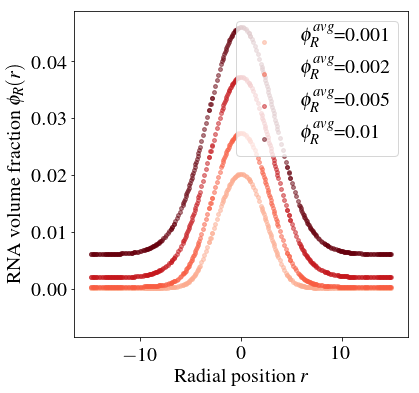

In [64]:
cmap = plt.get_cmap('Reds')
color_vals = np.linspace(0.3,1.0,len(phi_r_profiles))

fig,axs = plt.subplots(1,1,figsize=(6,6))
for i in range(len(phi_r_profiles)):
    axs.scatter(np.array(mesh.y[(mesh.x<0.05) * (mesh.x>-0.05)]),
                np.array(phi_r_profiles[i][(mesh.x<0.05) * (mesh.x>-0.05)]), 
                label=r"$\phi^{avg}_R$="+str(phi_r_list[i]), s=15, alpha=0.5,
                c = cmap(color_vals[i]))

axs.set_ylabel(r'RNA volume fraction $\phi_R(r)$')
axs.set_xlabel(r'Radial position $r$')
axs.legend()
plt.savefig("Figures for paper/RNA_conc_profile_eqbm_K_pt2.svg",format="svg")

In [65]:
def get_chemical_potential(phi_r, c_R, r):
    """
    Function that returns the chemical potential of the lncRNA given concentration and radial position
    """
    rho_r = 2.0
    N_R = 50
    sigma=5.0
    
    mu_r = (1.0 + np.log(phi_r))/N_R -(1.0+np.log(1-phi_r)) + 2*rho_r*phi_r - c_R*np.exp(-r**2/sigma**2)
    return mu_r
    

/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (56) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))
/home/npradeep96/miniconda3/envs/fipyenv/lib/python2.7/site-packages/matplotlib/textpath.py:389: UserWarning: The glyph (54) of font (/usr/share/texlive/texmf-dist/fonts/type1/urw/times/utmr8a.pfb) cannot be converted with the encoding. Glyph may be wrong
  "be wrong" % (glyph, font_bunch.filename))


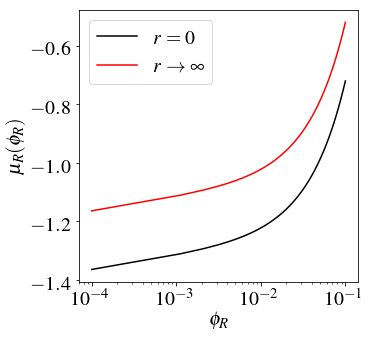

In [73]:
fig,axs = plt.subplots(1,1,figsize=(5,5))
phi_r = np.linspace(0.0001,0.1,100)
axs.plot(phi_r,get_chemical_potential(phi_r,0.2,0),'-k',label='$r=0$')
axs.plot(phi_r,get_chemical_potential(phi_r,0.2,500), '-r',label=r'$r \rightarrow \infty$')
axs.set_xscale('log')
axs.set_xlabel('$\phi_R$')
axs.set_ylabel('$\mu_R(\phi_R)$')
axs.legend()
plt.savefig('Figures for paper/RNA_eqbm_profile.svg',format='svg',dpi=1200)